# Recommendation System

If you choose the Recommendation System option, you will be making movie recommendations based on the [MovieLens](https://grouplens.org/datasets/movielens/latest/) dataset from the GroupLens research lab at the University of Minnesota.  Unless you are planning to run your analysis on a paid cloud platform, we recommend that you use the "small" dataset containing 100,000 user ratings (and potentially, only a particular subset of that dataset).

Your task is to:

> Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

The MovieLens dataset is a "classic" recommendation system dataset, that is used in numerous academic papers and machine learning proofs-of-concept.  You will need to create the specific details about how the user will provide their ratings of other movies, in addition to formulating a more specific business problem within the general context of "recommending movies".

#### Collaborative Filtering

At minimum, your recommendation system must use collaborative filtering.  If you have time, consider implementing a hybrid approach, e.g. using collaborative filtering as the primary mechanism, but using content-based filtering to address the [cold start problem](https://en.wikipedia.org/wiki/Cold_start_(computing)).

#### Evaluation

The MovieLens dataset has explicit ratings, so achieving some sort of evaluation of your model is simple enough.  But you should give some thought to the question of metrics.  Since the rankings are ordinal, we know we can treat this like a regression problem.  But when it comes to regression metrics there are several choices: RMSE, MAE, etc.  [Here](http://fastml.com/evaluating-recommender-systems/) are some further ideas.

### imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
movies= pd.read_csv('../../../data/movies.csv')

In [26]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
links= pd.read_csv('../../../data/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [11]:
ratings= pd.read_csv('../../../data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [12]:
tags= pd.read_csv('../../../data/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### merge ratings and movie title/genre

In [13]:
rated_movies=pd.merge(ratings, movies, on='movieId')
rated_movies.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [14]:
# drop timestamp
rated_movies = rated_movies.drop(['timestamp'],axis=1)
rated_movies.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [15]:
def proj_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)
proj_eda(rated_movies)

,null_sum,null_pct,dtypes,count,mean,median,min,max
genres,0,0.0,object,100836,NaN,NaN,(no genres listed),Western
movieId,0,0.0,int64,100836,19435.295718,2991.0,1,193609
rating,0,0.0,float64,100836,3.501557,3.5,0.5,5
title,0,0.0,object,100836,NaN,NaN,'71 (2014),À nous la liberté (Freedom for Us) (1931)
userId,0,0.0,int64,100836,326.127564,325.0,1,610


### get average rating and number of ratings

In [16]:
rated = pd.DataFrame(rated_movies.groupby('title')['rating'].mean())
rated.sort_values('rating', ascending=False)

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
...,...
Don't Look Now (1973),0.5
Journey 2: The Mysterious Island (2012),0.5
Joe Dirt 2: Beautiful Loser (2015),0.5


In [17]:
rated['num_rating'] = pd.DataFrame(rated_movies.groupby('title')['rating'].count())
rated.head()

,rating,num_rating
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [18]:
top_20=rated.sort_values('num_rating', ascending=False)[:20]

top_20.head()

,rating,num_rating
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


### some visualizing

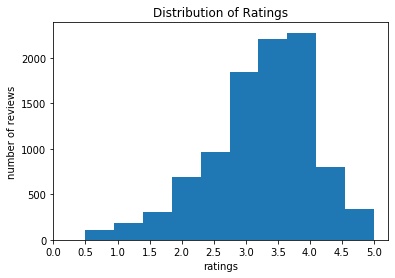

In [21]:
fig,ax = plt.subplots(1,1)
figsize=(20,16)
a = rated['rating']
ax.hist(a, bins = 10)
ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_title('Distribution of Ratings')
ax.set_xlabel('ratings')
ax.set_ylabel('number of reviews')
plt.show()

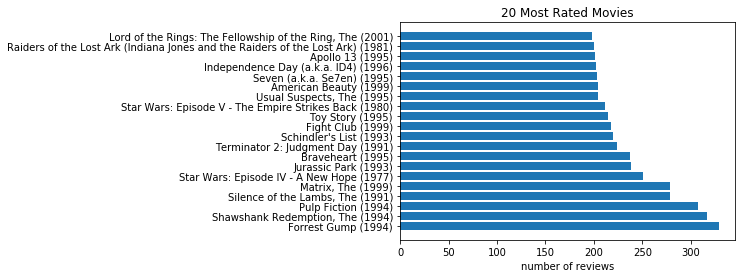

In [22]:
fig,ax = plt.subplots(1,1)
figsize=(30,20)

ax.barh(top_20.index, top_20.num_rating)
ax.set_title('20 Most Rated Movies')

ax.set_xlabel('number of reviews')
plt.show()

### matrix 

In [23]:
movie_matrix = rated_movies.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
